In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

### Load data and aggregate charts

In [3]:
df_filepaths = 'data/univ3/*.parquet'

### Monthly Blockchain Volume

In [101]:
def blockchain_monthly_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    '''
    Returns weekly volume for each blockchain in USD
    '''
    q = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('amountInUSD') < 150000000)
    .filter(pl.col('blockchain') == blockchain)
    .sort("timestamp", descending=False)
    .groupby_dynamic("timestamp",every='1w').agg(pl.col('amountInUSD').sum())
    .select(
        pl.col("timestamp").dt.truncate("1w"),
        pl.col("amountInUSD").alias("weekly_vol")
        )
    )

    df = q.collect()

    return df

In [102]:
eth_data = blockchain_monthly_vol(df_filepaths, 'ethereum')
arb_data = blockchain_monthly_vol(df_filepaths, 'arbitrum')
opt_data = blockchain_monthly_vol(df_filepaths, 'optimism')
poly_data = blockchain_monthly_vol(df_filepaths, 'polygon')
bsc_data = blockchain_monthly_vol(df_filepaths, 'bsc')

In [103]:
# rename columns
eth_data = eth_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('eth_vol')
)

arb_data = arb_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('arb_vol')
)

opt_data = opt_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('opt_vol')
)

poly_data = poly_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('poly_vol')
)

bsc_data = bsc_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('bsc_vol')
)

In [129]:
# merge dataframes
weekly_vol = eth_data.join(arb_data, on='timestamp').join(opt_data, on='timestamp').join(poly_data, on='timestamp').join(bsc_data, on='timestamp', how='outer')

In [130]:
# convert null to 0 
weekly_vol = weekly_vol.fill_null(0)

In [135]:
for index in range(1, weekly_vol.shape[1]):
    for col in weekly_vol.rows():
        print(col[0], weekly_vol.columns[index], '${:,.2f}'.format(col[index]))


2023-02-27 00:00:00 eth_vol $4,993,414,674.29

2023-03-06 00:00:00 eth_vol $26,227,335,347.15

2023-03-13 00:00:00 eth_vol $7,008,149,113.30

2023-03-20 00:00:00 eth_vol $6,363,532,853.44

2023-03-27 00:00:00 eth_vol $4,703,061,660.94

2023-04-03 00:00:00 eth_vol $3,548,395,077.32

2023-04-10 00:00:00 eth_vol $5,167,099,477.46

2023-04-17 00:00:00 eth_vol $3,852,289,539.13

2023-04-24 00:00:00 eth_vol $3,942,378,860.13

2023-05-01 00:00:00 eth_vol $5,952,830,222.72

2023-05-08 00:00:00 eth_vol $3,669,403,214.28

2023-05-15 00:00:00 eth_vol $3,306,331,881.11

2023-05-22 00:00:00 eth_vol $2,899,843,469.81

2023-02-27 00:00:00 arb_vol $1,016,111,796.46

2023-03-06 00:00:00 arb_vol $2,278,357,761.86

2023-03-13 00:00:00 arb_vol $2,066,320,182.13

2023-03-20 00:00:00 arb_vol $3,831,182,201.86

2023-03-27 00:00:00 arb_vol $3,207,360,528.18

2023-04-03 00:00:00 arb_vol $1,729,722,368.75

2023-04-10 00:00:00 arb_vol $3,357,158,911.10

2023-04-17 00:00:00 arb_vol $2,882,516,127.28

2023-04-24 

In [137]:
# sum each column to get total volume per column
total_vol_sum = weekly_vol.select(
    pl.sum('eth_vol'),
    pl.sum('arb_vol'),
    pl.sum('opt_vol'),
    pl.sum('poly_vol'),
    pl.sum('bsc_vol')
)

for index in range(total_vol_sum.shape[1]):
    for col in total_vol_sum.rows():
        print(total_vol_sum.columns[index], '${:,.2f}'.format(col[index]))

eth_vol $81,634,065,391.06
arb_vol $28,779,295,480.99
opt_vol $2,765,562,613.20
poly_vol $5,703,787,993.77
bsc_vol $5,481,873,668.75


### Plotting

In [107]:
# convert to pandas for plotting
pd_chart = weekly_vol.to_pandas()
# convert timestamp to datetime so it just shows the date, not the time.
# pd_monthly_chart['timestamp'] = pd.to_datetime(pd_monthly_chart['timestamp']).dt.date

In [108]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

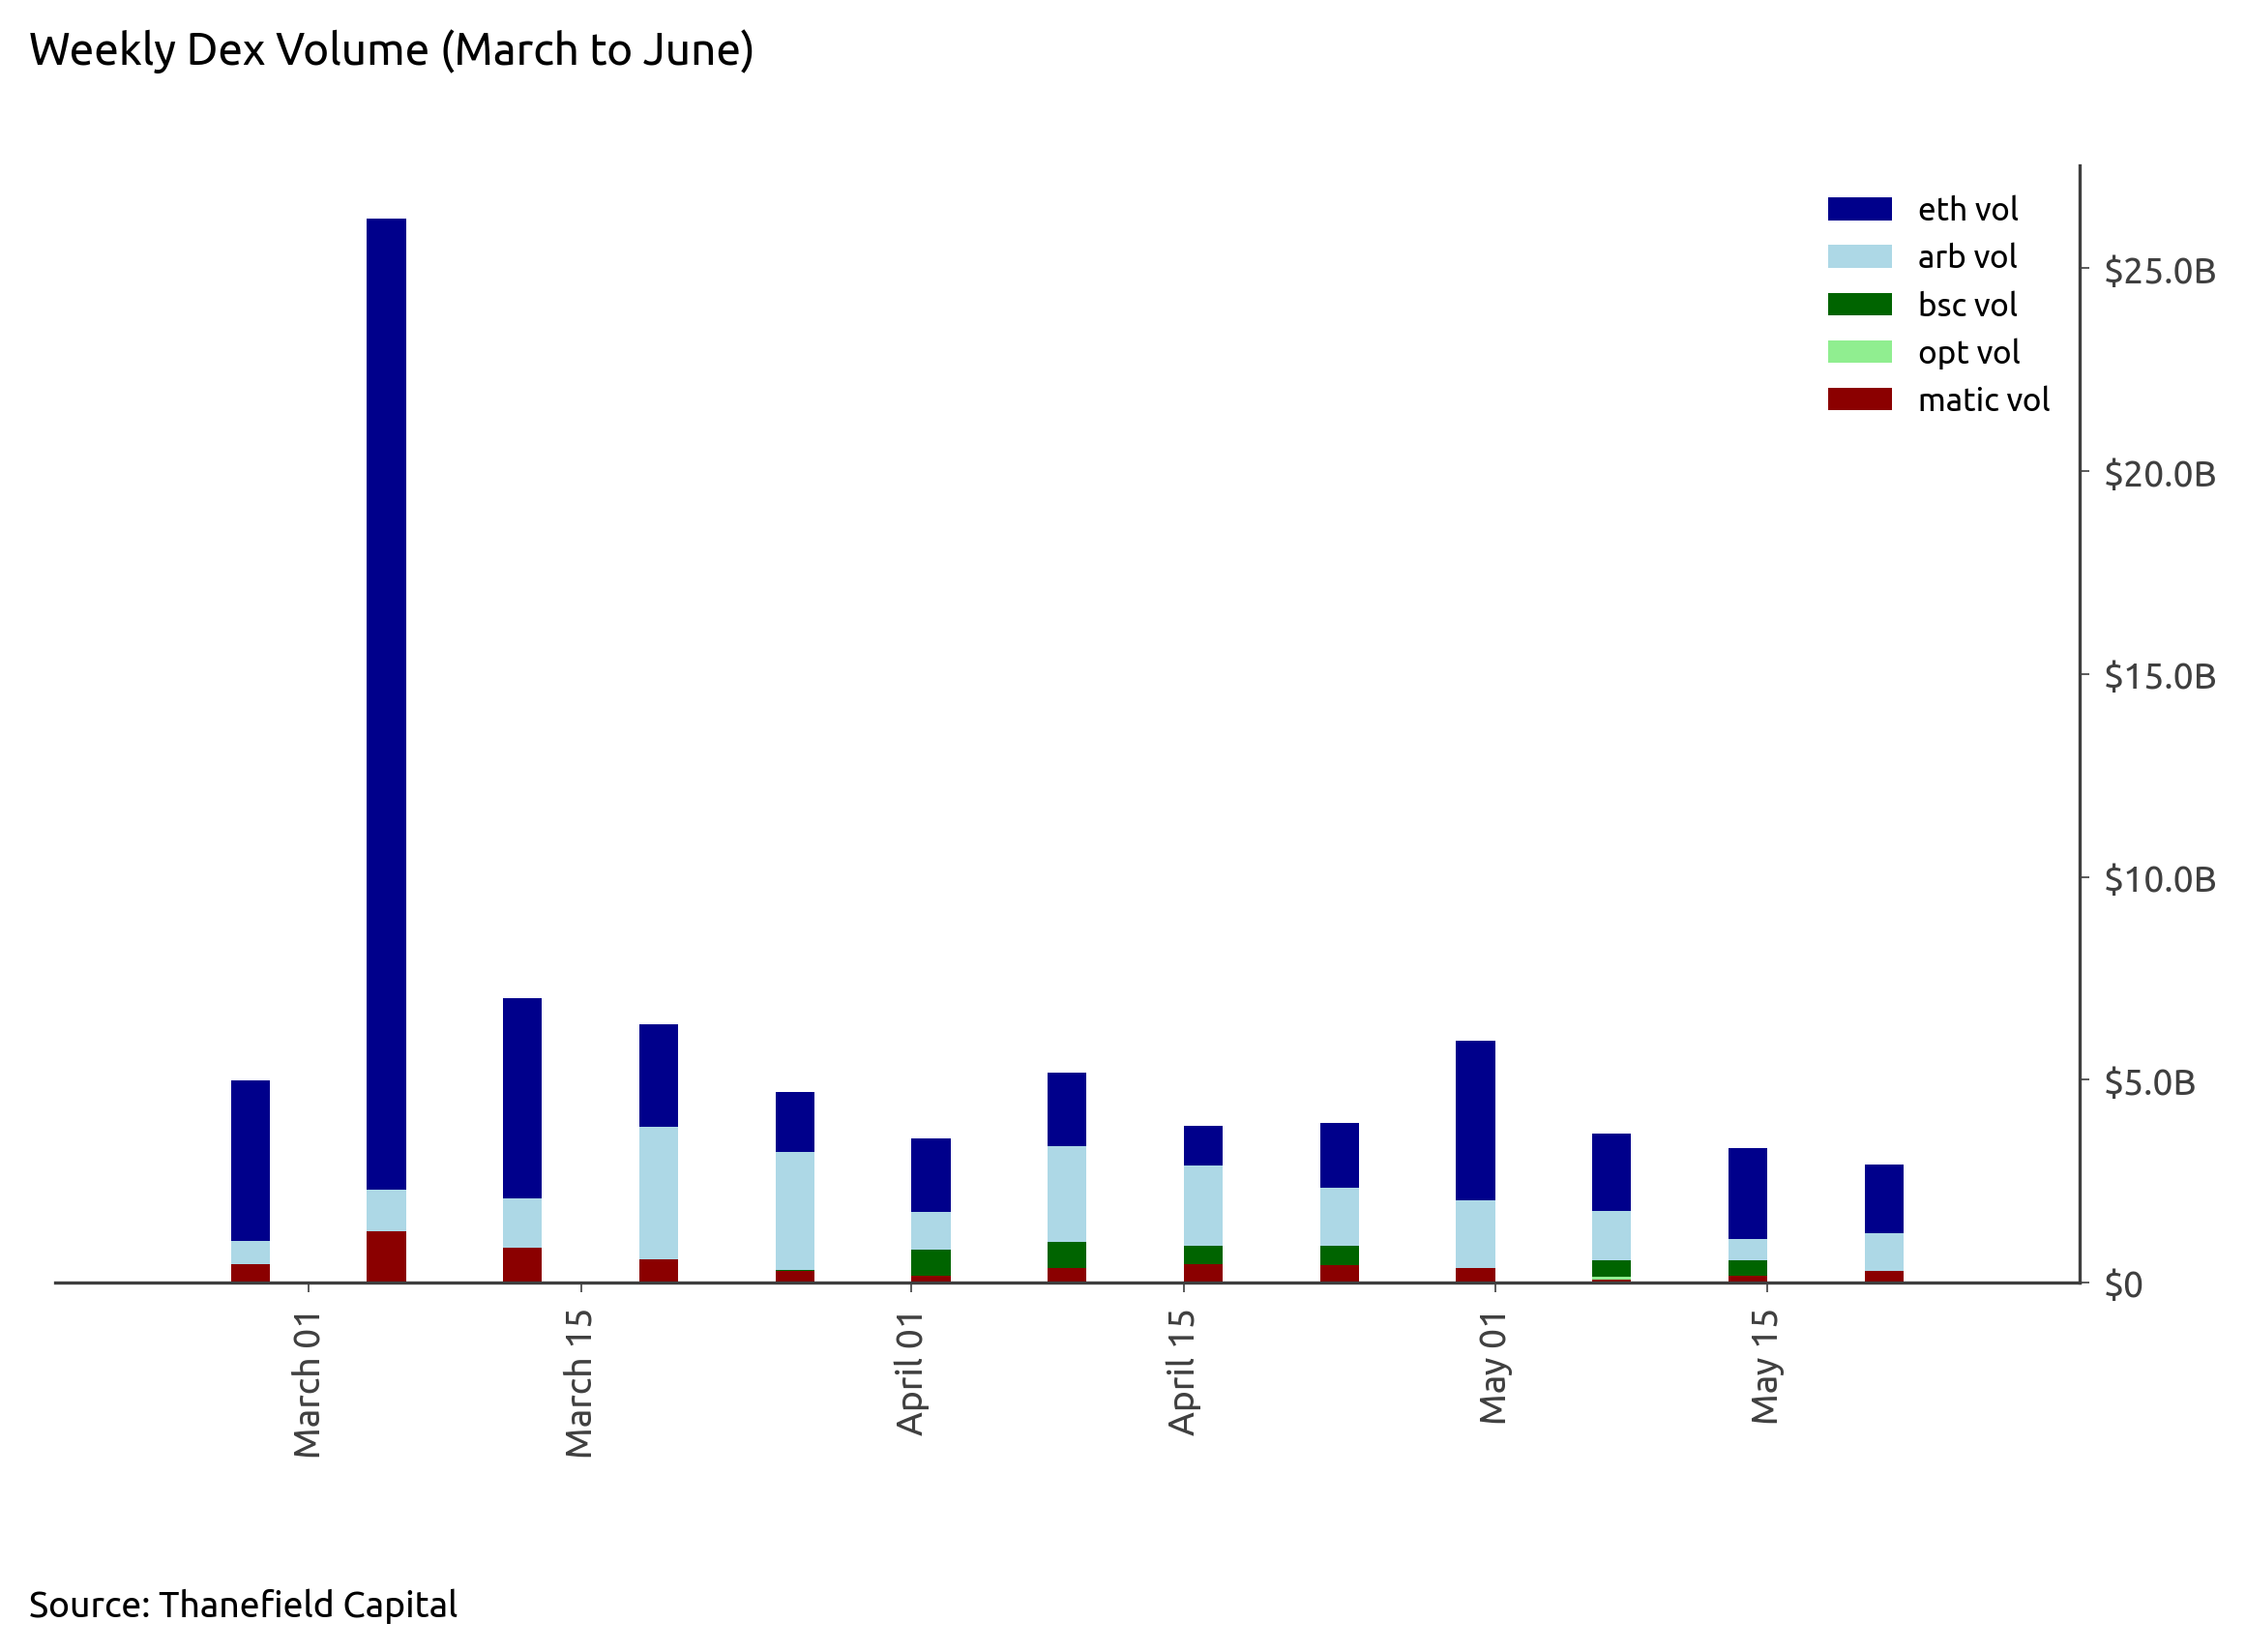

In [111]:
# Create the bar chart
fig, ax = tc.chart('Dex Weekly Volume (March to June)', dates=False)
ax.bar(pd_chart['timestamp'], pd_chart['eth_vol'], color='darkblue', label='eth vol', align='edge', width=-2)
ax.bar(pd_chart['timestamp'], pd_chart['arb_vol'], color='lightblue', label='arb vol', align='edge', width=-2)
ax.bar(pd_chart['timestamp'], pd_chart['bsc_vol'], color='darkgreen', label='bsc vol', align='edge', width=-2)
ax.bar(pd_chart['timestamp'], pd_chart['opt_vol'], color='lightgreen', label='opt vol', align='edge', width=-2)
ax.bar(pd_chart['timestamp'], pd_chart['poly_vol'], color='darkred', label='matic vol', align='edge', width=-2)


# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))


# formatting
tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
# plt.tight_layout()
plt.xticks(rotation=90)

# save chart
tc.save('charts/dex_weekly_vol.png')